<a href="https://colab.research.google.com/github/FedericoVaona99/Videogame_Programming_Project/blob/master/Programming_Project_Videogame_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **VideoGames: Metacritic Vs Userscore**

The Dataset is: https://www.kaggle.com/datasets/taranenkodaria/videogame-metacritic

**Short Description of feature/Columns:**

**titles** - game names

**platforms** - game platform, games can have an implementation on several platforms

**metascore** - the rating put down metacritic.com

**userscore** - user rating, may not be available for new games

**genre** - the game genre, games can have more than one genre

**date** - date of release

#Import of the dataset and all the libraries

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [118]:
videogames_df = pd.read_csv('metacritic_18.07.2021_csv.csv')

# Exploratory Data Analysis

I print the first and last rows of the dataset to see what data it contains and to check how I can improve it.

In [119]:
videogames_df.head(10)

,titles,platforms,metascore,userscore,genre,date
0,Streets of Rage 4: Mr. X Nightmare,PC,88.0,tbd,action,"July 15, 2021"
1,Sniper Elite VR,PC,67.0,7.1,action,"July 8, 2021"
2,Sniper Elite VR,PlayStation 4,75.0,tbd,action,"July 8, 2021"
3,Boomerang X,PC,81.0,6.6,action,"July 8, 2021"
4,Boomerang X,Switch,78.0,6.3,action,"July 8, 2021"
5,Space Jam: A New Legacy - The Game,Xbox One,51.0,tbd,action,"July 1, 2021"
6,Space Jam: A New Legacy - The Game,Xbox Series X,55.0,tbd,action,"July 1, 2021"
7,Curved Space,PC,60.0,tbd,action,"June 29, 2021"
8,Curved Space,PlayStation 5,56.0,tbd,action,"June 29, 2021"
9,Curved Space,Xbox Series X,75.0,tbd,action,"June 29, 2021"


In [120]:
videogames_df.tail()

,titles,platforms,metascore,userscore,genre,date
30772,WCW Backstage Assault,Nintendo 64,NaN,6.0,wrestling,"December 12, 2000"
30773,WWF SmackDown! 2: Know Your Role,PlayStation,90.0,8.4,wrestling,"November 21, 2000"
30774,WWF No Mercy,Nintendo 64,89.0,8.5,wrestling,"November 17, 2000"
30775,ECW Anarchy Rulz,PlayStation,NaN,6.4,wrestling,"August 18, 2000"
30776,WWF Royal Rumble,Dreamcast,66.0,6.4,wrestling,"August 1, 2000"


In [121]:
videogames_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30777 entries, 0 to 30776
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   titles     30777 non-null  object 
 1   platforms  30777 non-null  object 
 2   metascore  28486 non-null  float64
 3   userscore  25082 non-null  object 
 4   genre      30777 non-null  object 
 5   date       30777 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.4+ MB


We can see that there are 2291 null values for the metascore column
and there are 5695 null values for the userscore column

In [122]:
videogames_df.describe().T

,count,mean,std,min,25%,50%,75%,max
metascore,28486.0,72.278066,9.923171,50.0,65.0,73.0,80.0,98.0


It can be noted that the **maximum rating** value for a videogame obtained from the Metacritic site is 98.0, while the average value is 72.28.

Furthermore, it can be observed that information regarding the 'userscore' feature is missing. This is because it also contains string values, as it was decided to assign the value 'tbd' (to be decided) to titles that have been recently released or have not yet received a rating. Therefore, it is not currently possible to calculate the average value.

In [123]:
# I create the boolean mask to find all the 'tbd'
to_be_decided_mask = videogames_df.userscore == 'tbd'

videogames_df['userscore'][to_be_decided_mask].count()

5695

Videogames that still not have a userscore are 5695

In [124]:
videogames_df.shape

(30777, 6)

The dataset has 30777 rows and 6 columns

#Cleaning up the Dataset

First, I will modify the format of the data feature so that it can be correctly sorted (currently, they are strings).

In [125]:
# Convert date to datetime object
videogames_df['date'] = pd.to_datetime(videogames_df['date'])

Now I can see which is the oldest game that has yet to be rated by users.

In [126]:
videogames_df[to_be_decided_mask].sort_values(by='date').head()

,titles,platforms,metascore,userscore,genre,date
13382,Of Light and Darkness: The Prophecy,PC,58.0,tbd,adventure,1998-03-31
10773,Elemental Gearbolt,PlayStation,76.0,tbd,action,1998-06-30
24158,Flanker 2.0,PC,81.0,tbd,simulation,1999-09-30
16128,Flanker 2.0,PC,81.0,tbd,flight,1999-09-30
28625,Star Trek ConQuest Online,PC,63.0,tbd,strategy,2000-07-14


The oldest game that has yet to be rated by users is from 31 March 1998.

I also see that there are other games from the 2000s that do not have a rating, so I conclude that the 'tbd' value is not only for the most recent games.

As I noticed during the data exploration, the 'userscore' feature consists of strings. Therefore, I decide to replace the 'tbd' values with null values, and then transform the column in the same type of the metacritic feature ('float').

Then, to make the userscore comparable with the metascore, I will scale it to 100.

In [127]:
# First, I transform 'tbd' value in NaN value and convert the column in float type
videogames_df.loc[to_be_decided_mask,'userscore'] = np.nan
videogames_df.userscore = videogames_df.userscore.astype(float)

videogames_df.userscore = videogames_df.userscore * 10
videogames_df.userscore.head()

,userscore
0,NaN
1,71.0
2,NaN
3,66.0
4,63.0


To handle null values in the 'metascore' and 'userscore` columns, the options I consider most valid for this dataset are:

**Option 1)** Replace NaN and TBD values with the average score (same for the NaN values ​​of the metascore).

**Option 2)** Replace NaN and TBD values with the score that the game received from Metacritic and delete the row if the value is (NaN) for Metacritic as well.

I chose to implement Option 2 because I believe it is better for subsequent direct comparisons between metascore and userscore, as it reduces the influence of missing values and makes the data more complete and consistent for analysing distributions.

Option 1, given the large number of NaN or 'TBD' values for userscore (about 1/3 of the total), would have introduced an outlier and made accurate analysis more difficult.

In [128]:
# Replace NaN values ​​in 'userscore' with corresponding values ​​in 'metascore'
videogames_df['userscore'] = videogames_df.apply(
    lambda row: row['metascore'] if pd.isna(row['userscore']) else row['userscore'], axis=1
)

# Delete lines where both 'userscore' and 'metascore' are NaN
videogames_df.dropna(subset=['userscore', 'metascore'], inplace=True)
videogames_df = videogames_df.reset_index(drop=True)

videogames_df

,titles,platforms,metascore,userscore,genre,date
0,Streets of Rage 4: Mr. X Nightmare,PC,88.0,88.0,action,2021-07-15
1,Sniper Elite VR,PC,67.0,71.0,action,2021-07-08
2,Sniper Elite VR,PlayStation 4,75.0,75.0,action,2021-07-08
3,Boomerang X,PC,81.0,66.0,action,2021-07-08
4,Boomerang X,Switch,78.0,63.0,action,2021-07-08
...,...,...,...,...,...,...
28481,WWF Road to Wrestlemania,Game Boy Advance,62.0,62.0,wrestling,2001-11-18
28482,Fire Pro Wrestling,Game Boy Advance,80.0,80.0,wrestling,2001-06-10
28483,WWF SmackDown! 2: Know Your Role,PlayStation,90.0,84.0,wrestling,2000-11-21
28484,WWF No Mercy,Nintendo 64,89.0,85.0,wrestling,2000-11-17


I will convert metascore and userscore into integer columns since there are no metacritic or user ratings with decimal numbers.

In [129]:
videogames_df.userscore = videogames_df.userscore.astype(int)
videogames_df.metascore = videogames_df.metascore.astype(int)
videogames_df.head()


,titles,platforms,metascore,userscore,genre,date
0,Streets of Rage 4: Mr. X Nightmare,PC,88,88,action,2021-07-15
1,Sniper Elite VR,PC,67,71,action,2021-07-08
2,Sniper Elite VR,PlayStation 4,75,75,action,2021-07-08
3,Boomerang X,PC,81,66,action,2021-07-08
4,Boomerang X,Switch,78,63,action,2021-07-08


I check to ensure that no other null values remain.

In [130]:
videogames_df.isnull().sum()

,0
titles,0
platforms,0
metascore,0
userscore,0
genre,0
date,0


In [131]:
videogames_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28486 entries, 0 to 28485
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   titles     28486 non-null  object        
 1   platforms  28486 non-null  object        
 2   metascore  28486 non-null  int64         
 3   userscore  28486 non-null  int64         
 4   genre      28486 non-null  object        
 5   date       28486 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.3+ MB


I can now view the numeric information for both the user and Metacritic. The mean is very similar and the minimum and maximum values coincide.

I can also see data for the 'date' feature after expressing it in the datetime type. The oldest game is from 29Sep2012, while the newest is from 1Jul2021.

In [132]:
videogames_df.describe().T

,count,mean,min,25%,50%,75%,max,std
metascore,28486.0,72.278066,50.0,65.0,73.0,80.0,98.0,9.923171
userscore,28486.0,71.162431,50.0,64.0,72.0,78.0,98.0,9.598837
date,28486,2012-04-29 08:57:57.918978048,1994-09-30 00:00:00,2008-02-12 00:00:00,2012-10-09 00:00:00,2017-02-09 18:00:00,2021-07-16 00:00:00,NaN


In [133]:
# Checking unique value of genre
videogames_df['genre'].unique()

array(['action', 'adventure', 'fighting', 'first-person', 'flight',
       'party', 'platformer', 'puzzle', 'racing', 'real-time',
       'role-playing', 'simulation', 'sports', 'strategy', 'third-person',
       'turn-based', 'wargame', 'wrestling'], dtype=object)

In [134]:
# Checking unique value of platforms
videogames_df['platforms'].unique()

array(['PC', 'PlayStation 4', 'Switch', 'Xbox One', 'Xbox Series X',
       'PlayStation 5',
       'iOS\n                                                                                    \xa0(Apple Arcade)',
       'iOS', 'Stadia', '3DS', 'PlayStation Vita', 'Wii U',
       'PlayStation 3', 'Xbox 360', 'PSP', 'Wii', 'DS', 'PlayStation 2',
       'Game Boy Advance', 'GameCube', 'Xbox', 'PlayStation', 'Dreamcast',
       'Nintendo 64'], dtype=object)

I rename the iOS Apple Arcade platform.

In [135]:
# Cleaning platforms name iOS/n...(Apple Arcade) to iOS (Apple Arcade)
videogames_df.loc[videogames_df['platforms'] == 'iOS\n                                                                                    \xa0(Apple Arcade)','platforms'] = 'iOS (Apple Arcade)'
videogames_df['platforms'].unique()

array(['PC', 'PlayStation 4', 'Switch', 'Xbox One', 'Xbox Series X',
       'PlayStation 5', 'iOS (Apple Arcade)', 'iOS', 'Stadia', '3DS',
       'PlayStation Vita', 'Wii U', 'PlayStation 3', 'Xbox 360', 'PSP',
       'Wii', 'DS', 'PlayStation 2', 'Game Boy Advance', 'GameCube',
       'Xbox', 'PlayStation', 'Dreamcast', 'Nintendo 64'], dtype=object)

I rewrite column name at singular

In [136]:
videogames_df = videogames_df.rename(columns={
    'titles': 'title',
    'platforms': 'platform',
    'metascore': 'metascore',
    'userscore': 'userscore',
    'genre': 'genre',
    'date': 'date'
})
videogames_df

,title,platform,metascore,userscore,genre,date
0,Streets of Rage 4: Mr. X Nightmare,PC,88,88,action,2021-07-15
1,Sniper Elite VR,PC,67,71,action,2021-07-08
2,Sniper Elite VR,PlayStation 4,75,75,action,2021-07-08
3,Boomerang X,PC,81,66,action,2021-07-08
4,Boomerang X,Switch,78,63,action,2021-07-08
...,...,...,...,...,...,...
28481,WWF Road to Wrestlemania,Game Boy Advance,62,62,wrestling,2001-11-18
28482,Fire Pro Wrestling,Game Boy Advance,80,80,wrestling,2001-06-10
28483,WWF SmackDown! 2: Know Your Role,PlayStation,90,84,wrestling,2000-11-21
28484,WWF No Mercy,Nintendo 64,89,85,wrestling,2000-11-17


Export the cleaned Dataset

In [137]:
#from google.colab import files

#videogames_df.to_csv('clean_dataset.csv', index=False)
#files.download('clean_dataset.csv')

#Show some interesting plot

I find the number of games per genre

In [138]:
videogames_df.genre.value_counts()

,count
genre,
action,9930
role-playing,2573
adventure,2456
strategy,2369
first-person,1892
sports,1810
racing,1368
simulation,1209
platformer,976


I find the number of games per platform

In [139]:
videogames_df.platform.value_counts()

,count
platform,
PC,7611
iOS,3689
PlayStation 4,2528
Xbox 360,1970
Switch,1858
Xbox One,1845
PlayStation 3,1629
PlayStation 2,1293
DS,948


I create the function to display histograms.

In [140]:
def plot_bar(fig_size, datas, col = 'blue', title = '', x_lab = '', y_lab = '', rot=0 ):
  plt.figure(figsize = fig_size)
  bars = plt.bar(datas.index, datas.values, color=col)
  plt.title(title)
  plt.xlabel(x_lab)
  plt.ylabel(y_lab)
  plt.xticks(rotation= rot)

  # Annotation of values over the bars
  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10) # position where to write the value
  plt.show()

Show how many games there are for each Genre.

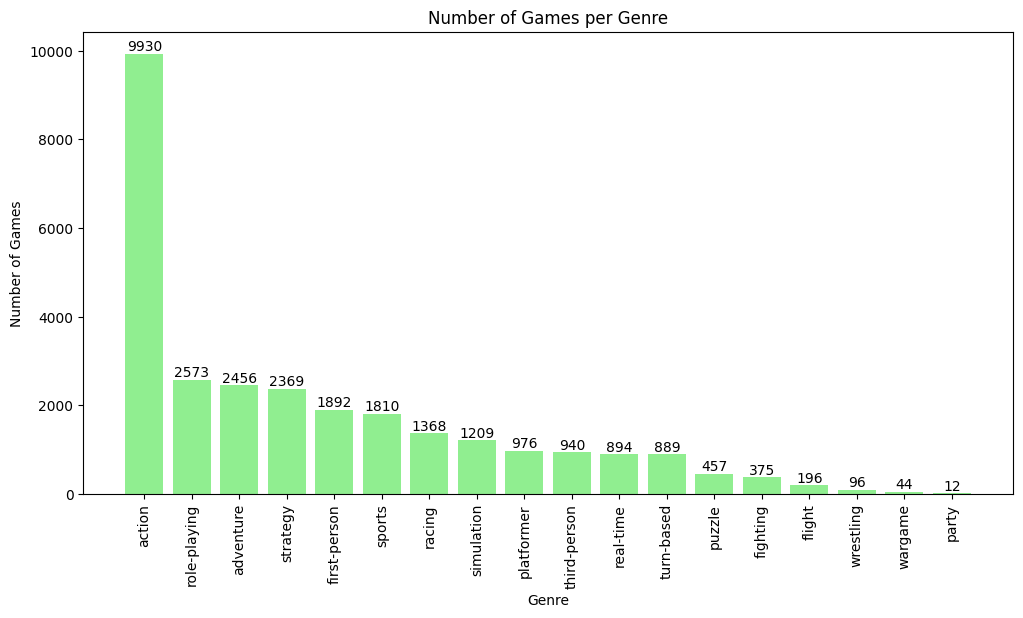

In [141]:
# number of games for each genre
genre_counts = videogames_df['genre'].value_counts()
plot_bar((12,6), genre_counts, col = 'lightgreen', title= 'Number of Games per Genre', x_lab= 'Genre', y_lab= 'Number of Games', rot = 90 )

Show how many games there are for each platform.

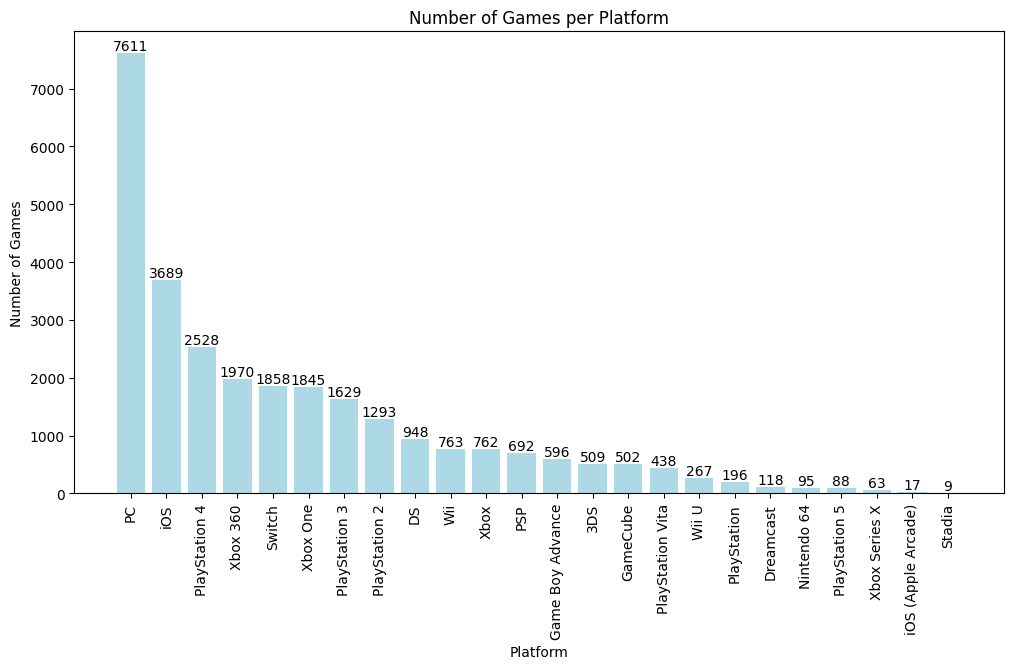

In [142]:
# number of games for each platform
platform_counts = videogames_df['platform'].value_counts()
plot_bar((12,6), platform_counts, col = 'lightblue', title= 'Number of Games per Platform', x_lab= 'Platform', y_lab= 'Number of Games', rot = 90 )



Comparation between the Metacritic and the userscore ratings

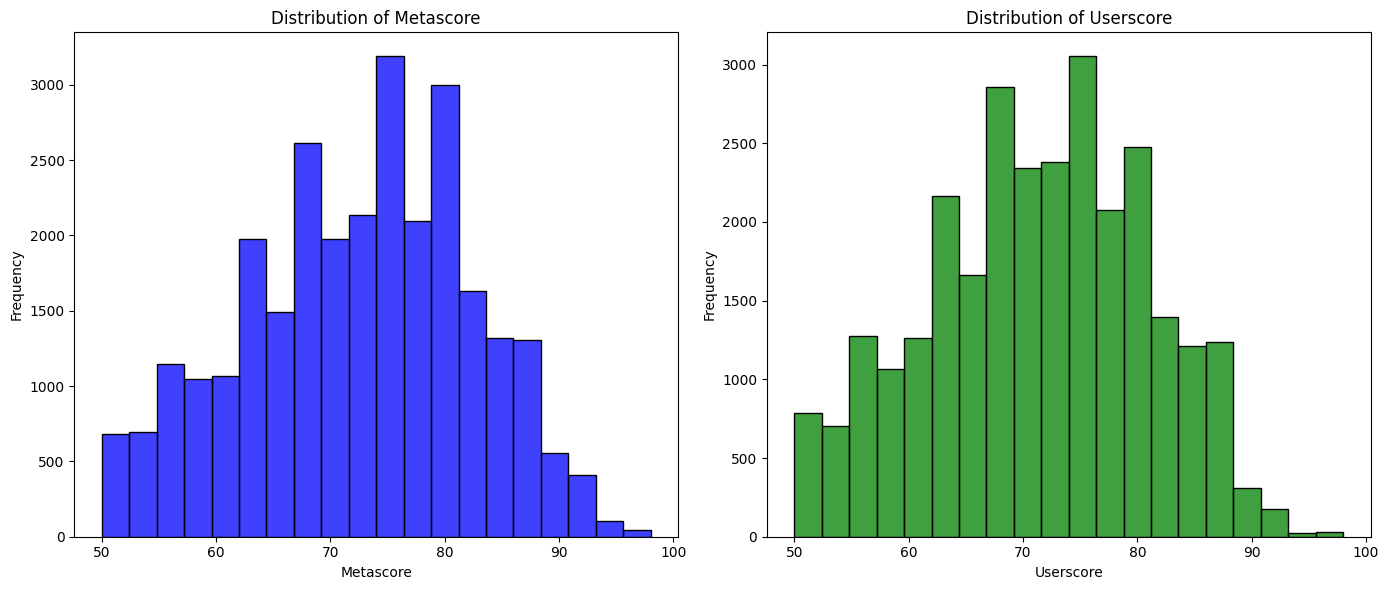

In [143]:
plt.figure(figsize=(14, 6))

# Histogram per Metascore with 50 bin
plt.subplot(1, 2, 1)
hist_metascore = sn.histplot(videogames_df['metascore'].dropna(), bins=20, color='blue')
plt.title('Distribution of Metascore')
plt.xlabel('Metascore')
plt.ylabel('Frequency')

# Histogram per Userscore with 50 bin
plt.subplot(1, 2, 2)
hist_userscore = sn.histplot(videogames_df['userscore'].dropna(), bins=20, color='green')
plt.title('Distribution of Userscore')
plt.xlabel('Userscore')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

I plot the 2 distributions together for comparison

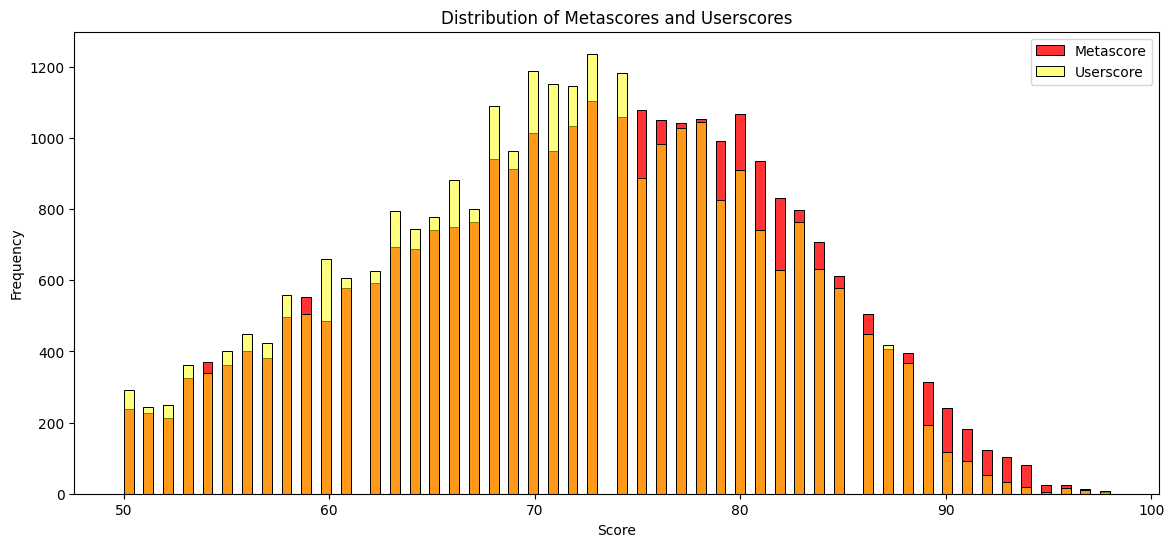

In [144]:
plt.figure(figsize=(14, 6))

# Metascore's Distribution
sn.histplot(videogames_df['metascore'], bins=100, color='red', label='Metascore', alpha=0.8)

# Userscore's Distribution
sn.histplot(videogames_df['userscore'], bins=100, color='yellow', label='Userscore', alpha=0.5)

plt.title('Distribution of Metascores and Userscores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


We can see from the comparison that Metacritic ratings tend to be higher than userscores.

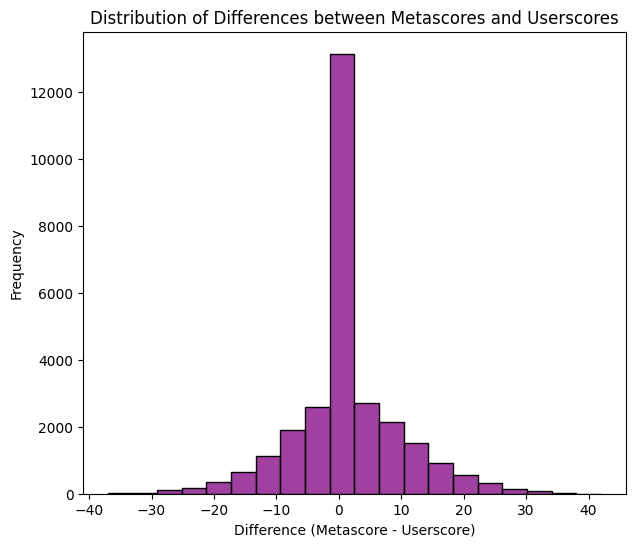

In [145]:
# Computation of differences between metascores and userscores
score_diff_df = videogames_df.copy()
score_diff_df['score_diff'] = videogames_df['metascore'] - videogames_df['userscore']

# Plot of the Distribution of differences
plt.figure(figsize=(7, 6))
sn.histplot(score_diff_df['score_diff'], bins=20, color='purple')
plt.title('Distribution of Differences between Metascores and Userscores')
plt.xlabel('Difference (Metascore - Userscore)')
plt.ylabel('Frequency')
plt.show()

In the distribution of the differences between the Metacritic and player scores, there is a peak at 0. This is due to the decision to substitute NaN values in the user scores with the corresponding metascore.

However, it is interesting to note that small differences are more frequent, while large differences happen rarely, indicating that the Metacritic scores and player scores often align.

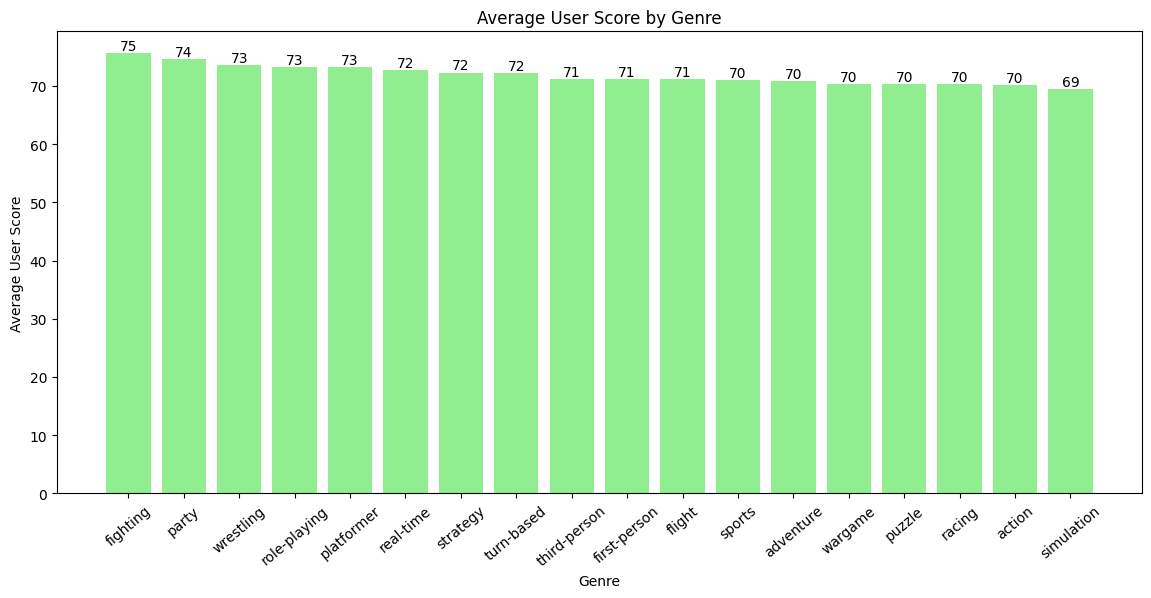

In [146]:
# Average User Score by Genre
genre_avg_score = videogames_df.groupby('genre')['userscore'].mean().sort_values(ascending=False)
plot_bar(fig_size=(14, 6), datas=genre_avg_score,
        col='lightgreen',
        title='Average User Score by Genre',
        x_lab='Genre',
        y_lab='Average User Score',
        rot=40 )

We can notice that the average rating of video games does not differ significantly depending on the game genre. However, the 'fighting' genre seems to be the most favored, while the 'simulation' genre has the lowest average rating. Still, the difference between the two genres is only 6 points

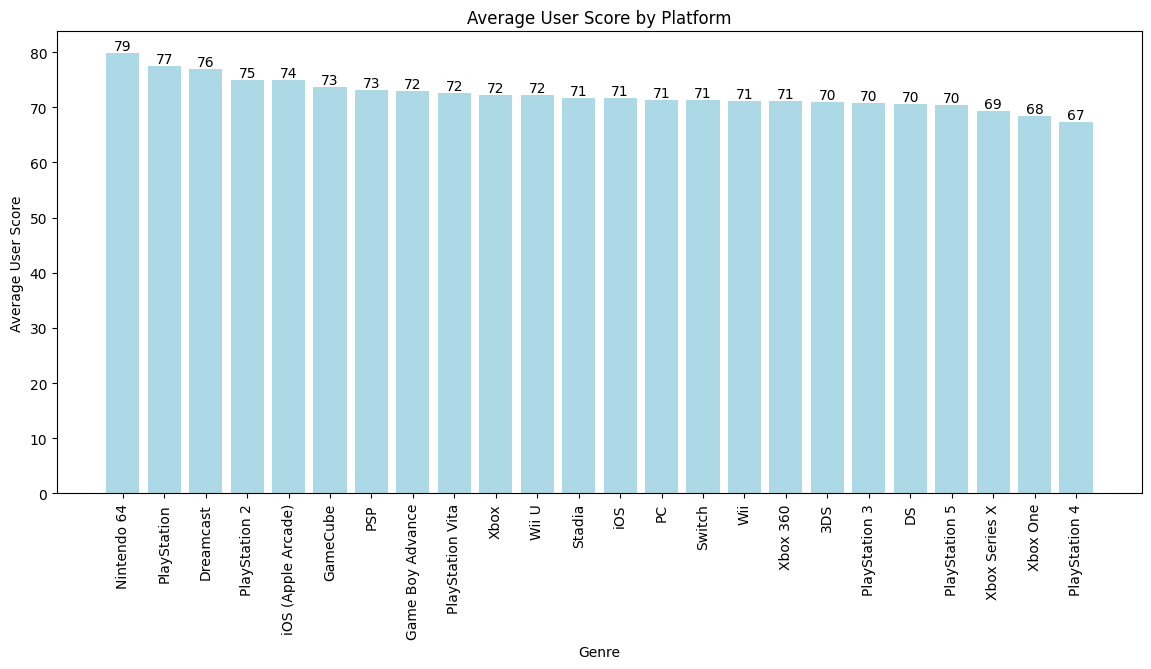

In [147]:
# Average User Score by Platform
platform_avg_score = videogames_df.groupby('platform')['userscore'].mean().sort_values(ascending=False)

plot_bar(fig_size=(14, 6), datas=platform_avg_score,
        col='lightblue',
        title='Average User Score by Platform',
        x_lab='Genre',
        y_lab='Average User Score',
        rot=90 )


We can notice that the console with the highest average rating is the Nintendo 64, while the PS4 has the lowest average rating.

It also appears that older consoles generally have higher ratings than the newer ones.

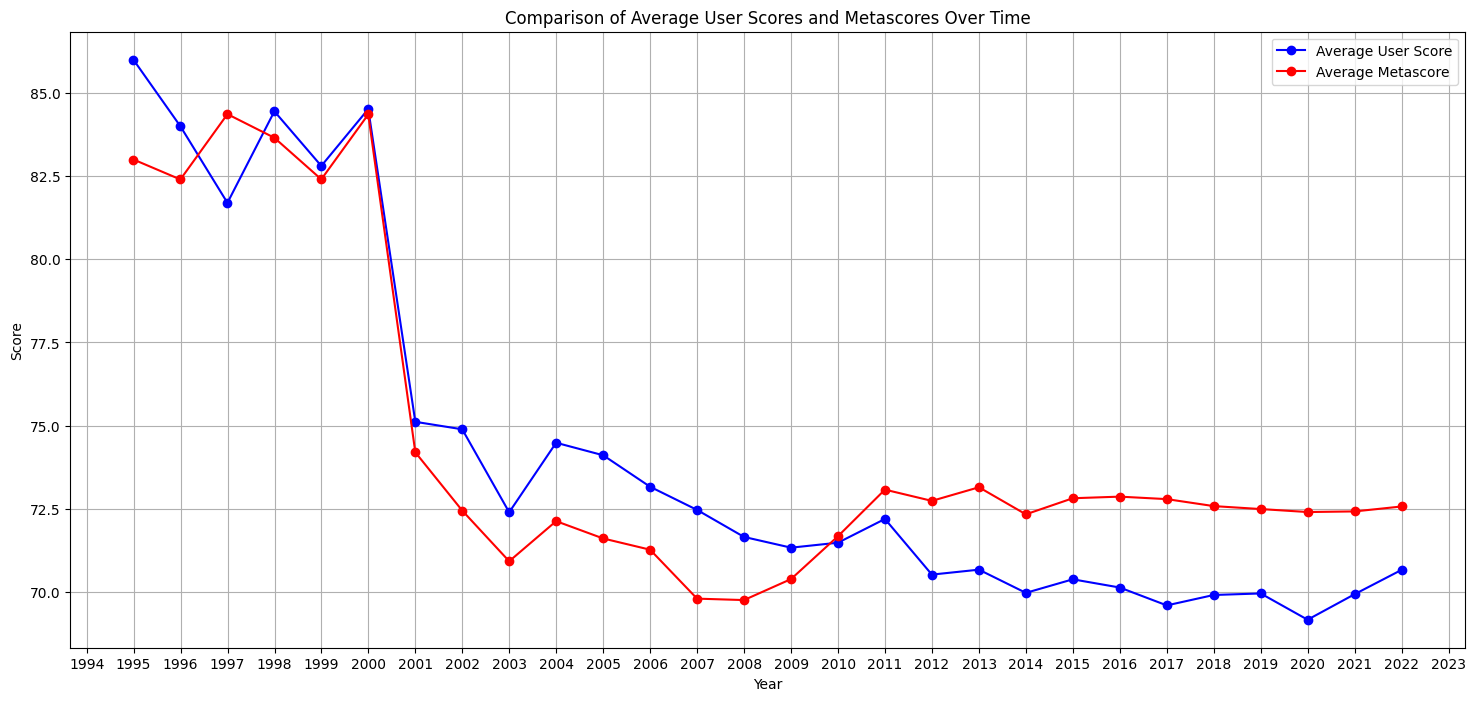

In [148]:
videogames_df.set_index('date',inplace=True)

# Resample the data by year and calculate the average user score for each year
yearly_avg_userscores = videogames_df['userscore'].resample('Y').mean()

# Resample the data by year and calculate the average metascore for each year
yearly_avg_metascores = videogames_df['metascore'].resample('Y').mean()


plt.figure(figsize=(18, 8))

# Plot the average user score per year
plt.plot(yearly_avg_userscores.index, yearly_avg_userscores.values, label='Average User Score', marker='o', color='blue')
# Plot the average metascore per year
plt.plot(yearly_avg_metascores.index, yearly_avg_metascores.values, label='Average Metascore', marker='o', color='red')

ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator()) # Set the major ticks on the x-axis to be for each year

plt.title('Comparison of Average User Scores and Metascores Over Time')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


The graph shows a decline in both user and metascores from 1994 to 2007, with a significant drop after 2000. Post 2008/2009, metascores remain slightly higher than user scores, with both stabilizing around the low 70s.

In [149]:
videogames_df.reset_index(inplace=True)

# Convert the 'date' column to datetime and extract the year
videogames_df['date'] = pd.to_datetime(videogames_df['date'])
videogames_df['year'] = videogames_df['date'].dt.year

# Group by year and find the index of the highest metascore for each year
idx = videogames_df.groupby('year')['metascore'].idxmax()
# Select the rows with the highest metascore for each year
best_games_per_year = videogames_df.loc[idx]
# Reset the index for the final output
best_games_per_year.reset_index(drop=True, inplace=True)

best_games_per_year[['title','platform','genre','metascore','userscore','year']]

,title,platform,genre,metascore,userscore,year
0,DOOM II,PC,action,83,83,1994
1,Command & Conquer,PC,real-time,94,89,1995
2,Super Mario 64,Nintendo 64,action,94,94,1996
3,GoldenEye 007,Nintendo 64,action,96,96,1997
4,Half-Life,PC,action,96,96,1998
5,SoulCalibur,Dreamcast,action,98,98,1999
6,Tony Hawk's Pro Skater 2,PlayStation,sports,98,74,2000
7,Halo: Combat Evolved,Xbox,action,97,97,2001
8,Metroid Prime,GameCube,action,97,97,2002
9,Super Mario Advance 4: Super Mario Bros. 3,Game Boy Advance,action,94,94,2003


In [150]:
# Group by year and find the index of the highest userscore for each year
idx = videogames_df.groupby('year')['userscore'].idxmax()
# Select the rows with the highest userscore for each year
best_games_per_year = videogames_df.loc[idx]
# Reset the index for the final output
best_games_per_year.reset_index(drop=True, inplace=True)

best_games_per_year[['title','platform','genre','metascore','userscore','year']]

,title,platform,genre,metascore,userscore,year
0,DOOM II,PC,first-person,83,89,1994
1,Command & Conquer,PC,real-time,94,89,1995
2,Super Mario 64,Nintendo 64,action,94,94,1996
3,GoldenEye 007,Nintendo 64,action,96,96,1997
4,Half-Life,PC,action,96,96,1998
5,SoulCalibur,Dreamcast,action,98,98,1999
6,Perfect Dark,Nintendo 64,action,97,97,2000
7,Halo: Combat Evolved,Xbox,action,97,97,2001
8,Metroid Prime,GameCube,action,97,97,2002
9,Super Mario Advance 4: Super Mario Bros. 3,Game Boy Advance,action,94,94,2003


Correlation and Correlation matrices

In [151]:
# Correlation between metascore and userscore
correlation = videogames_df['metascore'].corr(videogames_df['userscore'])
correlation

0.6136716980029892

Plot of the correlational matrix without categorical datas

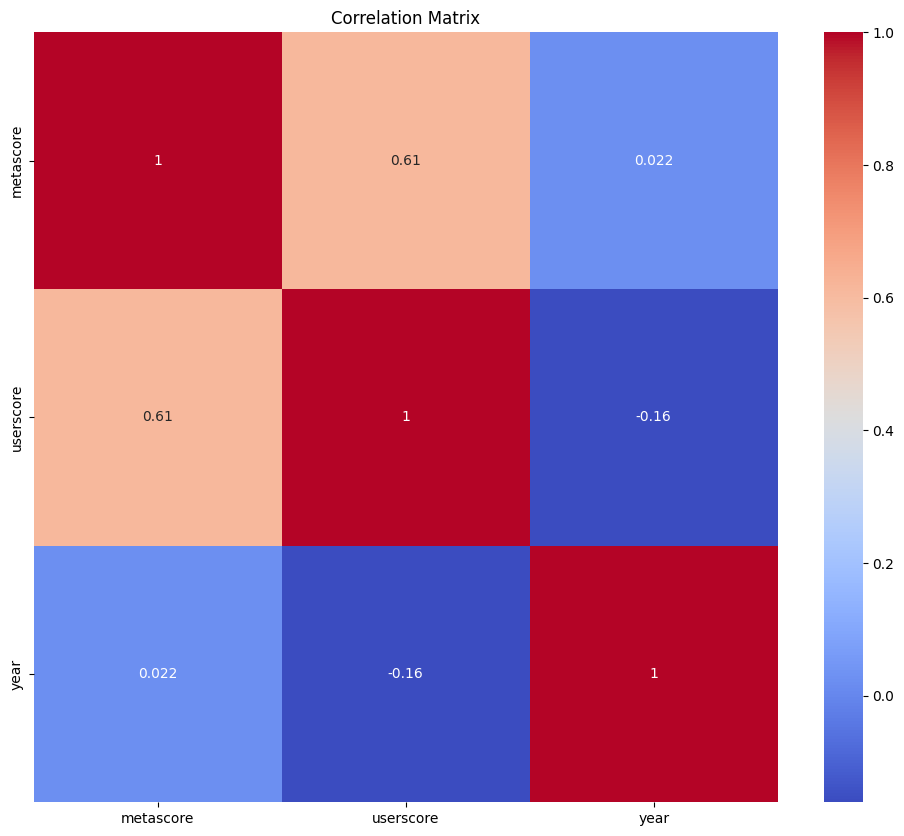

In [152]:
fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = videogames_df.corr(numeric_only=True)
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

Adding categorical datas

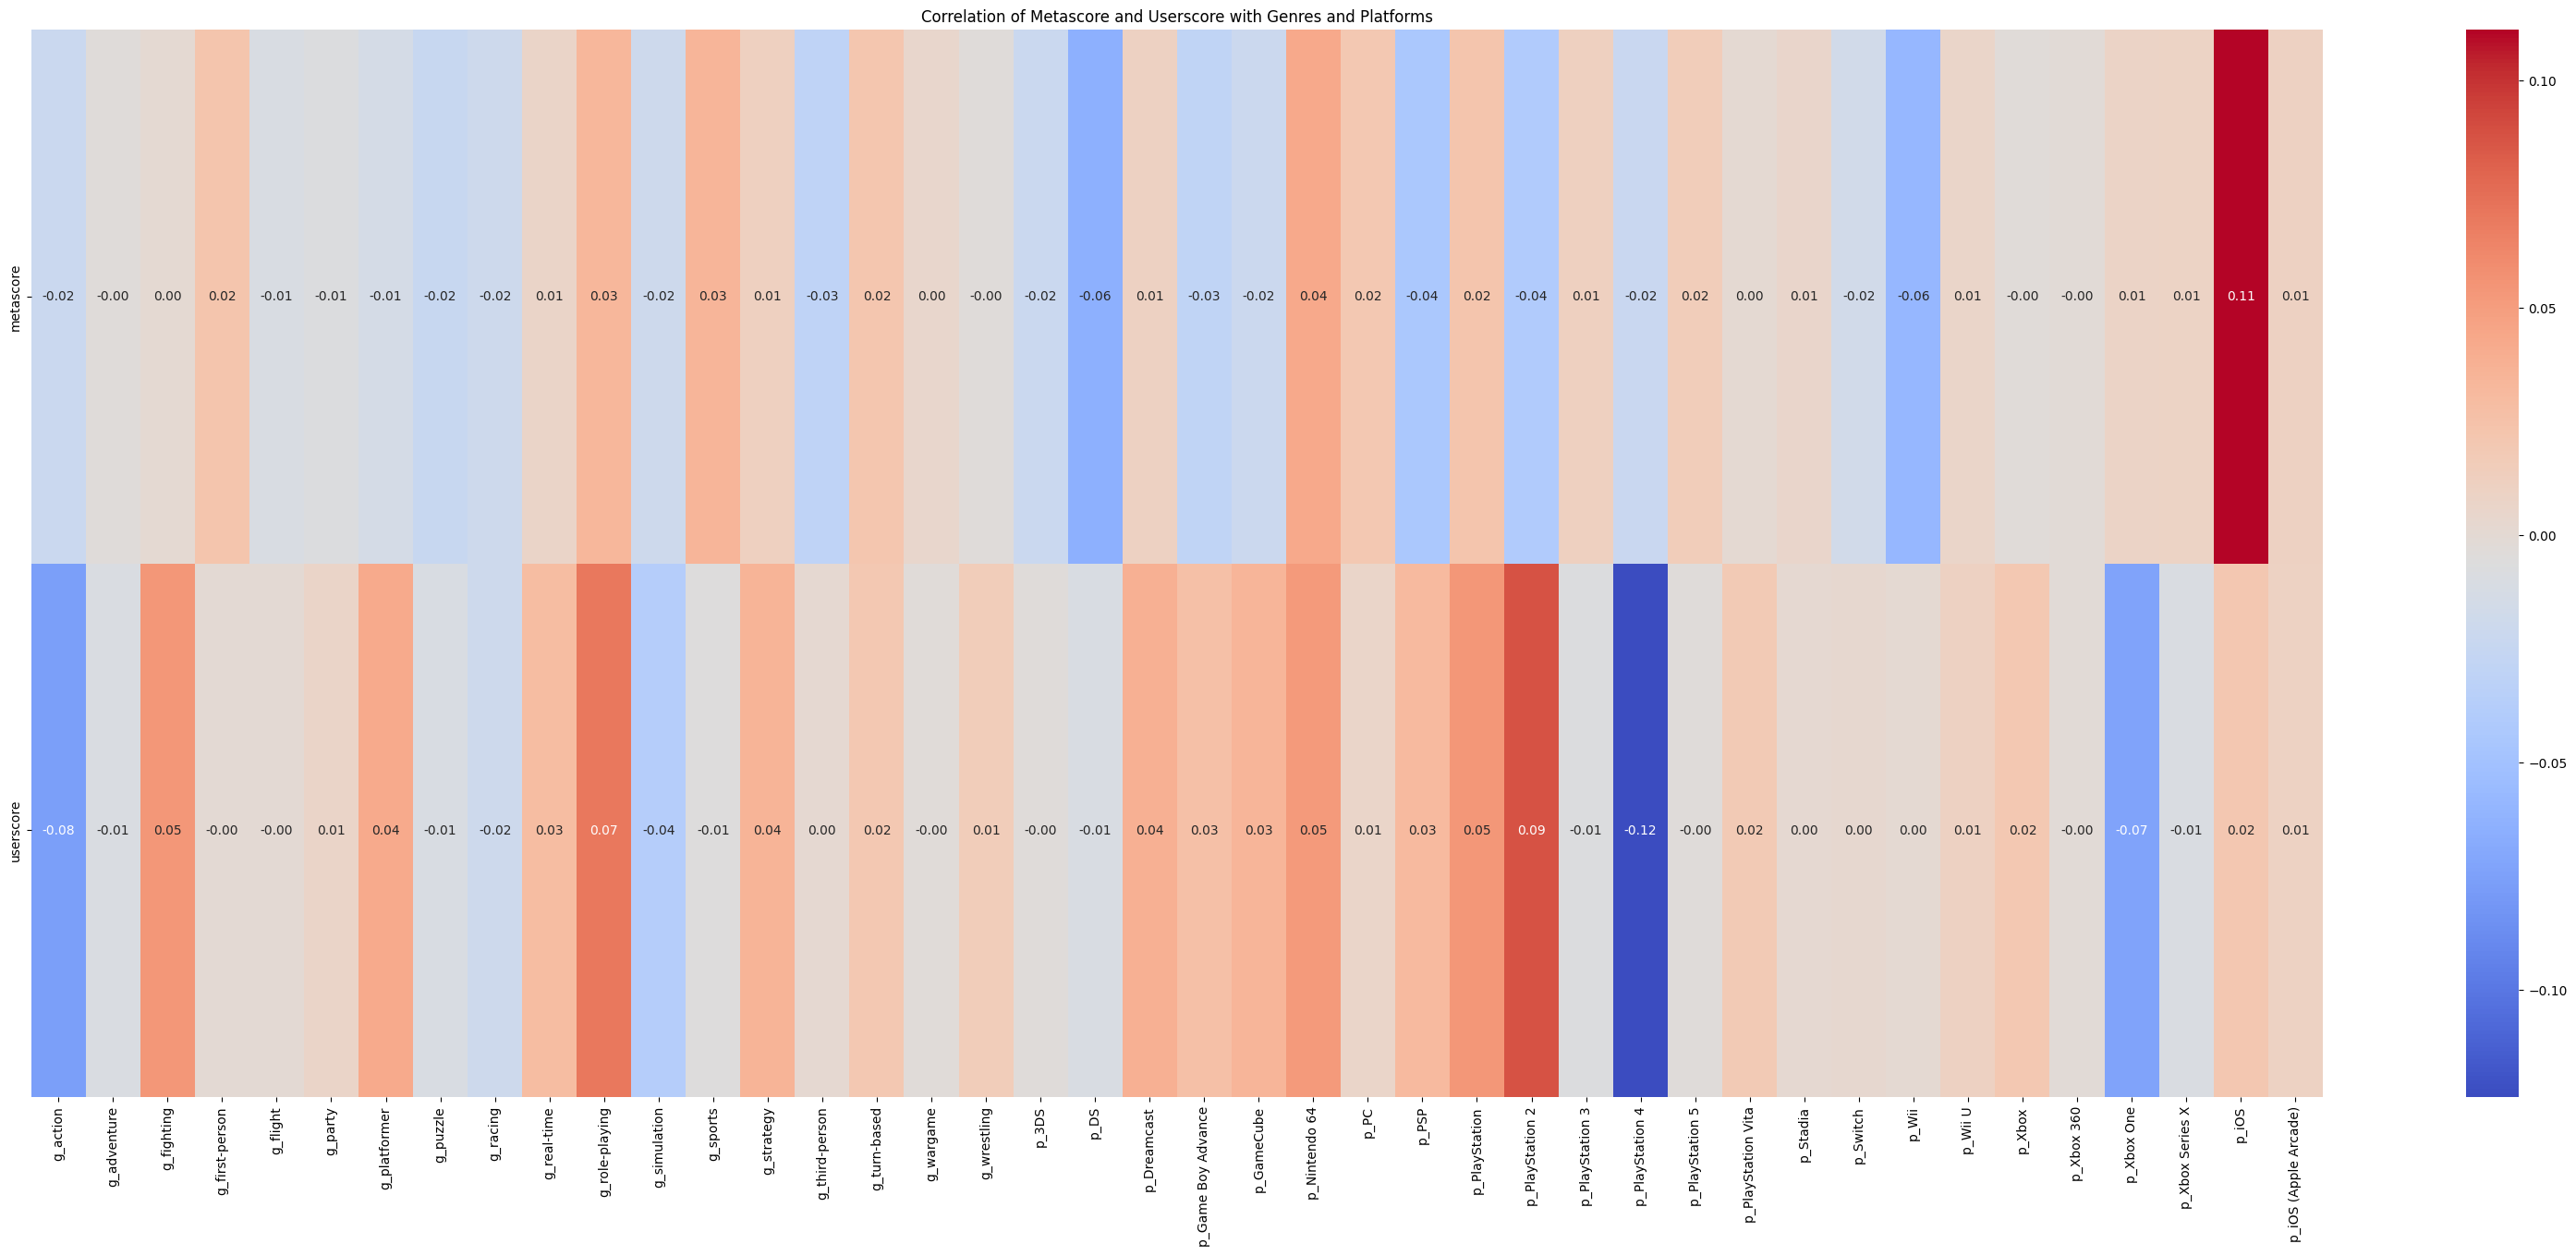

In [153]:
# One-Hot Encode 'genre' and 'platform'
genre_encoded = pd.get_dummies(videogames_df['genre'], prefix='g')
platform_encoded = pd.get_dummies(videogames_df['platform'], prefix='p')

# Combine the encoded columns with the original DataFrame
encoded_df = pd.concat([videogames_df[['metascore', 'userscore']], genre_encoded, platform_encoded], axis=1)

# Compute the correlation matrix
correlation_matrix = encoded_df.corr()

# For better visualization, focus only on how 'metascore' and 'userscore' correlate with genres and platforms
focus_correlation = correlation_matrix.loc[['metascore', 'userscore'], genre_encoded.columns.union(platform_encoded.columns)]

plt.figure(figsize=(40, 15))
sn.heatmap(focus_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Metascore and Userscore with Genres and Platforms')
plt.show()


In order to obtain more clarity, i will plot only the top 5 for genre and platform of the categorical datas

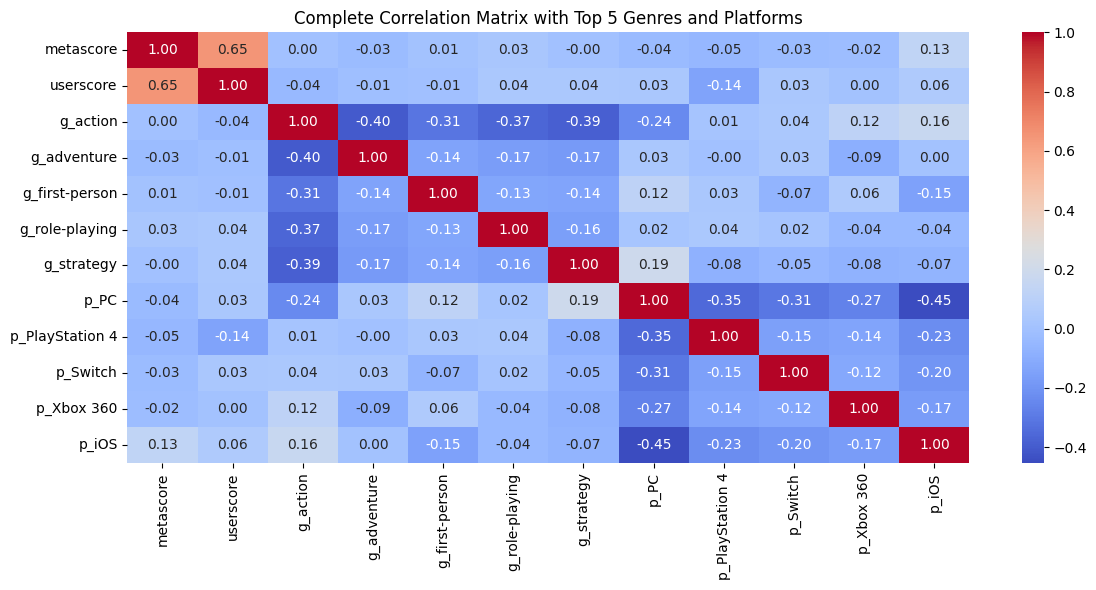

In [154]:
# Identify the top 5 genres and platforms based on occurrence
top_genres = videogames_df['genre'].value_counts().head(5).index.tolist()
top_platforms = videogames_df['platform'].value_counts().head(5).index.tolist()

# Filter the DataFrame to include only rows with top genres and platforms
filtered_df = videogames_df[
videogames_df['genre'].isin(top_genres) &
videogames_df['platform'].isin(top_platforms)
]

# One-Hot Encode 'genre' and 'platform' for the filtered DataFrame
genre_encoded = pd.get_dummies(filtered_df['genre'], prefix='g')
platform_encoded = pd.get_dummies(filtered_df['platform'], prefix='p')

# Combine the encoded columns with the original DataFrame
encoded_df = pd.concat([filtered_df[['metascore', 'userscore']], genre_encoded, platform_encoded], axis=1)

# Compute the correlation matrix for all variables
correlation_matrix = encoded_df.corr()

# Plotting the complete correlation matrix
plt.figure(figsize=(len(correlation_matrix.columns), len(correlation_matrix.columns) * 0.5))  # Size the figure to fit all variables
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Complete Correlation Matrix with Top 5 Genres and Platforms')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Ensure y-axis labels are horizontal for better readability
plt.tight_layout()  # Adjust layout to not cut off labels

# Find models that explain the data

#Classification

**Classification by Metascore:** The model try to classify the videogames in a **succesfull** game for the players or **not successful** knowing only the score obtained by metacritic.

All models of classification together (threshold userscore>75)

In [155]:
# Load the dataset
df = pd.read_csv('clean_dataset.csv')

# Define success threshold and create target variable
success_threshold = 75  # Userscore threshold for success
df['success'] = np.where(df['userscore'] >= success_threshold, 1, 0)  # 1 = success

# Select features and target variable
features = df[['metascore']]
target = df['success']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=22),    # A linear model that predicts the probability of class membership.
    'Support Vector Machine': SVC(random_state=22),   # Attempts to find the hyperplane that best separates the classes.
    'Gradient Boosting': GradientBoostingClassifier(random_state=22),  # Combines the predictions of several base estimators to improve robustness.
    'K-Nearest Neighbors': KNeighborsClassifier(),   # Classifies based on the most common class among the nearest neighbors.
    'Random Forest': RandomForestClassifier(random_state=22)   #  It's an ensemble of decision trees and usually performs well with fewer tuning requirements.
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Display results
for model_name, metrics in results.items():
    print(f"{model_name} Results:")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print("-" * 30)


Logistic Regression Results:
Accuracy: 0.7506
Precision: 0.7014
Recall: 0.5980
F1 Score: 0.6455
------------------------------
Support Vector Machine Results:
Accuracy: 0.7715
Precision: 0.6928
Recall: 0.7158
F1 Score: 0.7041
------------------------------
Gradient Boosting Results:
Accuracy: 0.7794
Precision: 0.6840
Recall: 0.7791
F1 Score: 0.7285
------------------------------
K-Nearest Neighbors Results:
Accuracy: 0.7503
Precision: 0.6863
Recall: 0.6308
F1 Score: 0.6574
------------------------------
Random Forest Results:
Accuracy: 0.7794
Precision: 0.6840
Recall: 0.7791
F1 Score: 0.7285
------------------------------


Plot of the results together

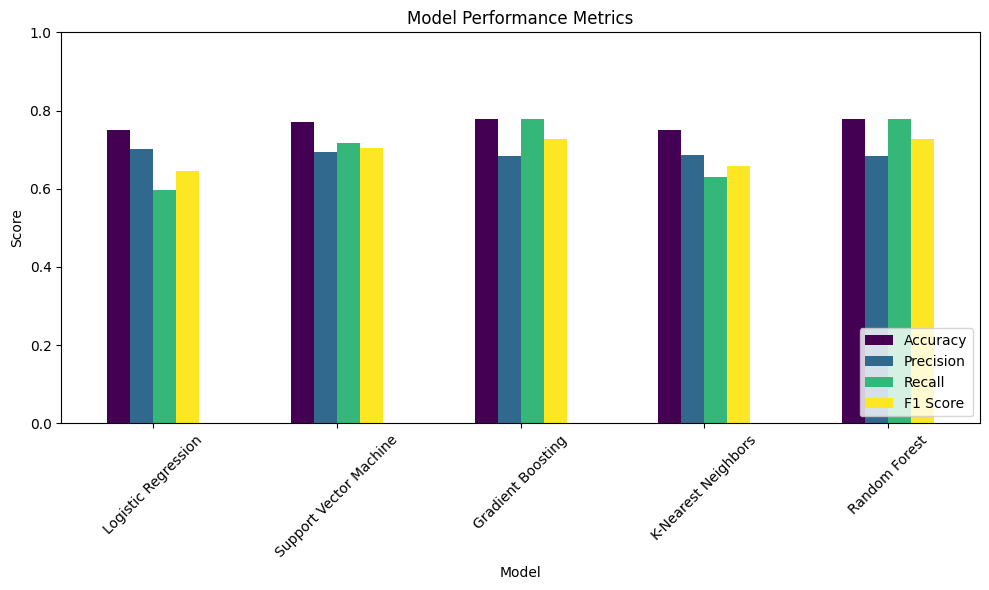

In [156]:
# Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(results).T

# Plot the results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
results_df[metrics].plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Model Performance Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


visualize confusion matrix

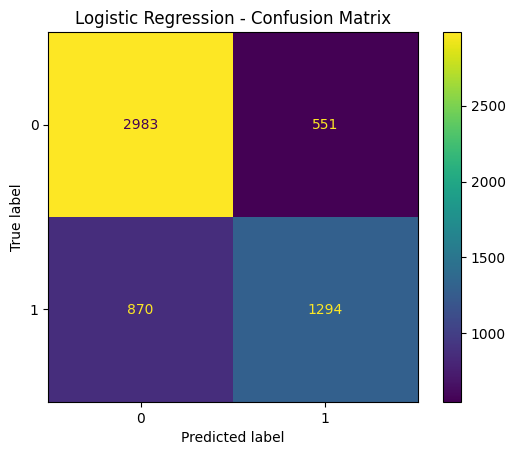

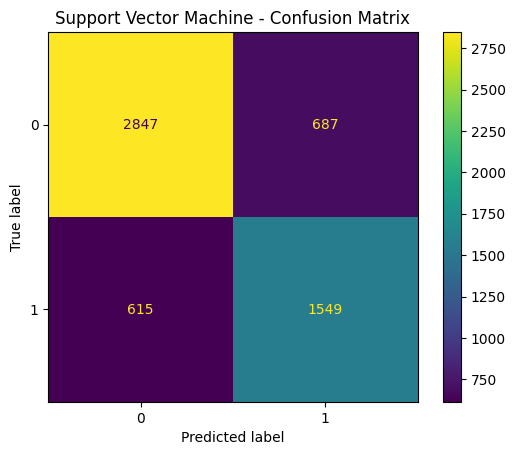

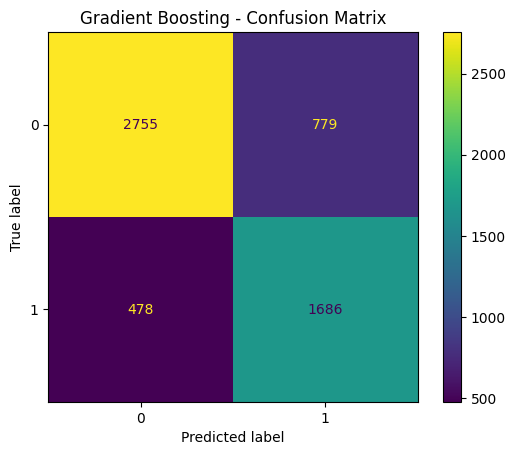

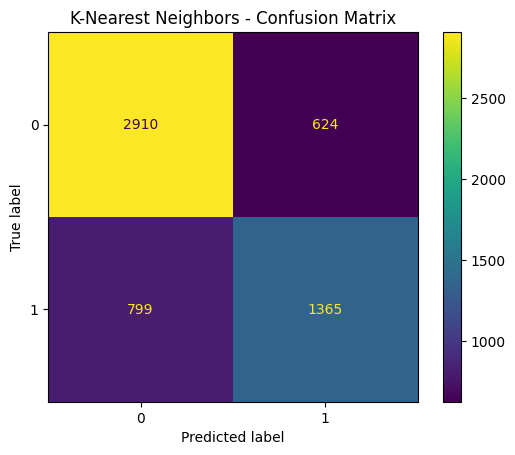

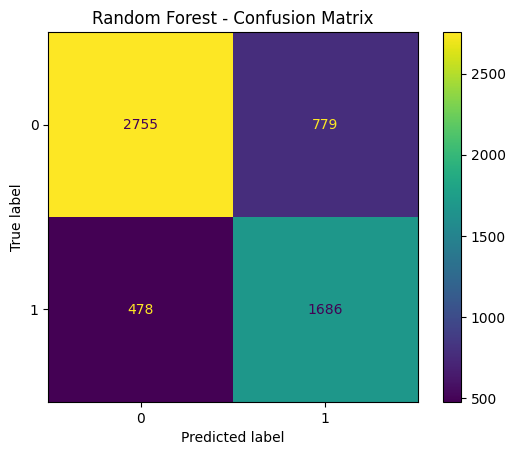

In [157]:
# Load the dataset
df = pd.read_csv('clean_dataset.csv')

# Define success threshold and create target variable
success_threshold = 75  # Userscore threshold for success
df['success'] = np.where(df['userscore'] >= success_threshold, 1, 0)  # 1 = success

# Select features and target variable
features = df[['metascore']]
target = df['success']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=22),
    'Support Vector Machine': SVC(random_state=22),
    'Gradient Boosting': GradientBoostingClassifier(random_state=22),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=22)
}

# Train each model and display confusion matrix
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    # Plot confusion matrix
    disp.plot(cmap='viridis')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()


**Classification by Genre and Platform:** The model try to classify the videogames in one of these 3 categories -> [Good, Average, Bad] knowing only the genre and the platform of the videogame.

In [158]:
# Function to prepare the data
def prepare_data(df, features):
    # Define categories based on metascore
    bins = [0, 65, 80, 100]  # Defines the ranges for "Bad", "Average", "Good"
    labels = ['Bad Game', 'Average Game', 'Good Game']
    df['category'] = pd.cut(df['metascore'], bins=bins, labels=labels, include_lowest=True)

    # Prepare the predictor variables using the selected features
    X_final = df[features]

    # Apply One-Hot Encoding if 'genre' or 'platform' are in the features
    if 'genre' in features or 'platform' in features:
        X_final = pd.get_dummies(X_final, columns=[col for col in ['genre', 'platform'] if col in features])

    # Define the target variable
    y = df['category']

    return X_final, y

# Load the dataset
df = pd.read_csv('clean_dataset.csv')

# Select the features to be used for the model
# Exclude columns that are not relevant for the training
features = df.drop(columns=['title', 'metascore', 'userscore', 'date']).columns.tolist()

# Prepare the data using the function
X, y = prepare_data(df, features)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Create a Random Forest classification model
model = RandomForestClassifier(n_estimators=100, random_state=22)
model.fit(X_train, y_train)

# Predict categories on the test set
y_pred = model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Accuracy: 50.97%
Classification Report:
              precision    recall  f1-score   support

Average Game       0.52      0.94      0.67      2951
    Bad Game       0.34      0.06      0.11      1444
   Good Game       0.38      0.03      0.05      1303

    accuracy                           0.51      5698
   macro avg       0.41      0.34      0.28      5698
weighted avg       0.44      0.51      0.39      5698

Confusion Matrix:
[[2778  128   45]
 [1340   91   13]
 [1220   48   35]]


On streamlit, the classification is interactive and you can select which features to add.